In [3]:
%load_ext autoreload
%autoreload 2
from utils import *
from hyperopt import hp
from pprint import pprint
from random import choice
from torch import distributions as dist
import inspect

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The Effects of Working Memory on Program Tracing

In this series of experiments, my goal is to understand how working memory affects our ability to mentally trace through a simple program. We are going to analyze the language of *arithmetic programs*, i.e. those containing numbers, binary operators, variables with assignment, and functions. Here's an example program demonstrating the full range of language features.

In [4]:
def f(x):
    y = x + 1
    return y + x

def g(z, q):
    return f(z - q)

g(1, 4)

-5

We will focus on the task of mentally computing the output of the function without use of external aids (pen/paper, calculator, etc.) except for the program listing. My ultimate goal is to produce a model that could predict the response time and accuracy of the average programmer tracing an arbitrary program. 

To focus on working memory, all arithmetic will be addition and subtraction, with all constants in the range 0-9. The main effects I'm interested in are how program state (variables + call stack) interact with working memory.

# 1. Variables

First, we need to create a model of working memory that fits experimental data on basic tracing tasks. For now, we will ignore functions and just consider variable assignment. Consider a program like this:

In [5]:
x = 1
y = x + 1
z = x - y
w = z + x
y - w

2

I hypothesize that a programmer will trace this code from top to bottom, and store variable/value pairs (e.g. x=1, y=2) in working memory. This raises a few key questions:
* How are variable/value pairs represented as chunks? e.g. is a pair one chunk, or is each part a separate chunk somehow associated to each other?
* How many variable/value pair chunks can a programmer store in memory? 

We'll start with the simplest "slots" model as used in visual working memory research. Assume working memory has $K$ slots. Each variable/value pair is a single slot (or chunk). When remembering a new chunk while at capacity, we randomly evict an existing chunk with uniform probability. This model is represented by the `WorkingMemory` class:

In [6]:

class BasicWM:
    def __init__(self, K):
        self.chunks = []
        self.max_chunks = K
        
    def maybe_forget(self):
        # Delete a random chunk once memory is at capacity
        if len(self.chunks) == self.max_chunks:
            self.chunks.remove(choice(self.chunks))        
        
    def store(self, variable, value):
        self.maybe_forget()
        self.chunks.append((variable, value))
        
    def load(self, variable):
        for (other_variable, value) in self.chunks:
            if variable == other_variable:
                return value
        return None
    
# Example of using BasicWM
wm = BasicWM(K=2)
wm.store("a", 1)
wm.store("b", 2)
assert wm.load("a") == 1
wm.store("c", 3)
assert len(wm.chunks) == 2

To evaluate whether this model usefully captures the phenomena of a human tracing a program, we start with a simple experiment.

## 1.1. Experiment 1: Variable span

In this experiment, we measure the number of variable/value pairs a participant can recall after a short delay. This task follows the same structure as many other kinds of span experiments (digit span, letter span, etc.) for measuring the capacity of working memory.


**Method:** for $N_{var} = 3 \ldots 6$, the participant is shown $N_{var}$ variable bindings. For example, at $N_{var} = 3$, the listing could be:

```python
x = 3
r = 8
w = 2
```

Each variable name is randomly selected (without replacement) from the letters a-z, and the constants are randomly selected from the digits 1-9. The order of the names is randomized as well. The participant is given $1.5 * N_{var}$ seconds to remember the variables. A blank screen is shown for 1 second, and then the participant is prompted with $N_{var}$ rows of two input boxes to recall the variable and value. 

The participant did 10 trials of the task for each value of $N_{var}$.

**Results:** for each trial, we computed the number of pairs where both the variable and value were correctly recalled. This distribution is shown below:

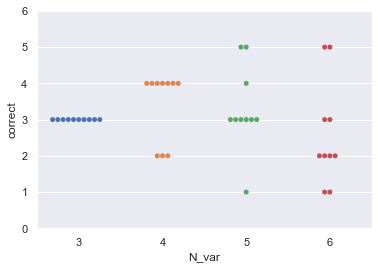

In [7]:
exp1 = VariableSpanExperiment()
def plot_actual(ax):
    sns.swarmplot(data=exp1.results(), x='N_var', y='correct', ax=ax)
    ax.set_yticks(list(range(0, 7)))
plot_actual(plt.gca())

These results suggest that the participant can remember 3 variables perfect, 4 variables mostly well, then with degrading performance for 5 and 6 variables. Two key observations: 
1. 5 and 6 variables have high variance. Performance ranges from perfect to a single variable remembered.
2. Performance actively degrades, rather than caps out.

## 1.2. Model simulation

Next, we will simulate performing the same task using the `BasicWM` model of working memory. In our simulation, we iterate through the observed variables, storing each to memory. Then, we try to fetch each variable. The code for the simulation is shown below.

In [8]:
print(inspect.getsource(exp1.simulate_trial))

    def simulate_trial(self, trial, model):
        wm = model()
        for v in trial['variables']:
            wm.store(v['variable'], v['value'])

        response = []
        for v in trial['variables']:
            value = wm.load(v['variable'])
            if value is not None:
                response.append({'variable': v['variable'], 'value': value})

        return response



Let's assume for now that the size of working memory is $K = $. We run the WM simulation for 1,000 trials per $N_{var}$ and report the distribution of correct answers, as above. On the left is the experimental data, and on the right is the simulated data.

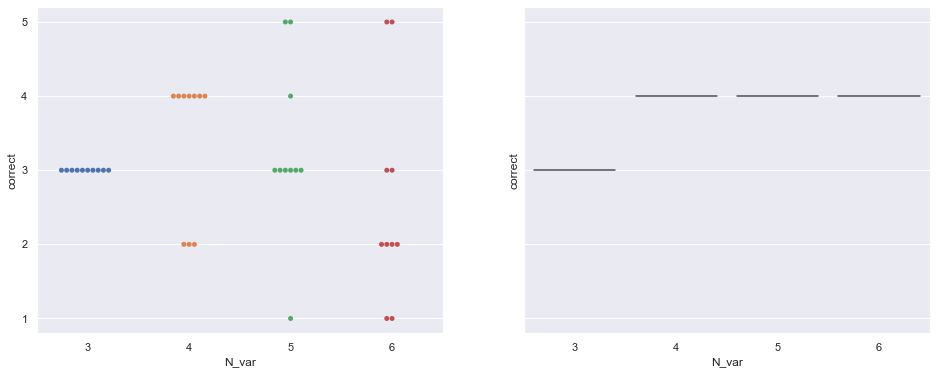

In [9]:
def plot_sim(sim_data):
    _, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    plot_actual(axes[0])
    sns.violinplot(
        data=sim_data,
        x='N_var',
        y='correct',
        cut=0, 
        ax=axes[1])
    
sim_data = exp1.simulate(lambda: BasicWM(K=4))
plot_sim(sim_data)

Our simulation performs as expected -- it memorizes perfectly up to K things, and gets the rest wrong. We can see that this doesn't match the actual noise of the experimental data, nor does it capture the decrease in performance as the number of chunks increases.

In [62]:
class SwapWM(BasicWM):
    def __init__(self, p_swap):
        self.chunks = []
        self.p_swap = p_swap
        
    def swap(self):
        if len(self.chunks) > 1:
            [i, j] = sample(range(len(self.chunks)), k=2)
            tmp = self.chunks[i][1]
            self.chunks[i] = (self.chunks[i][0], self.chunks[j][1])
            self.chunks[j] = (self.chunks[j][0], tmp)   

    def maybe_swap(self):
        if dist.Bernoulli(self.p_swap).sample().item() == 1.:
            self.swap()
            
    def store(self, variable, value):
        self.chunks.append((variable, value))
        self.maybe_swap()        

  0%|          | 544/9223372036854775807 [02:00<565737060442041:14:40,  4.53trial/s, best loss: 3.066666666666667] 
Best params: 
{'p_swap': 0.2961510972084168}
Parameter space: 


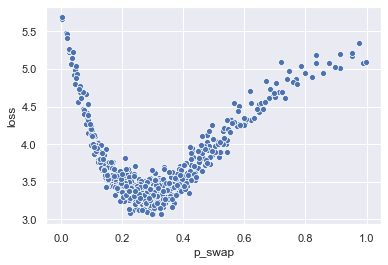

In [64]:
swap_param_space = [
    hp.uniform('p_swap', 0, 1)
]

swap_best_params, swap_all_params = pcache.get(
    'swap_params', lambda: exp1.param_search(SwapWM, swap_param_space))

print('Best params: ')
pprint(swap_best_params)
print('Parameter space: ', )
sns.scatterplot(data=swap_all_params, x='p_swap', y='loss')

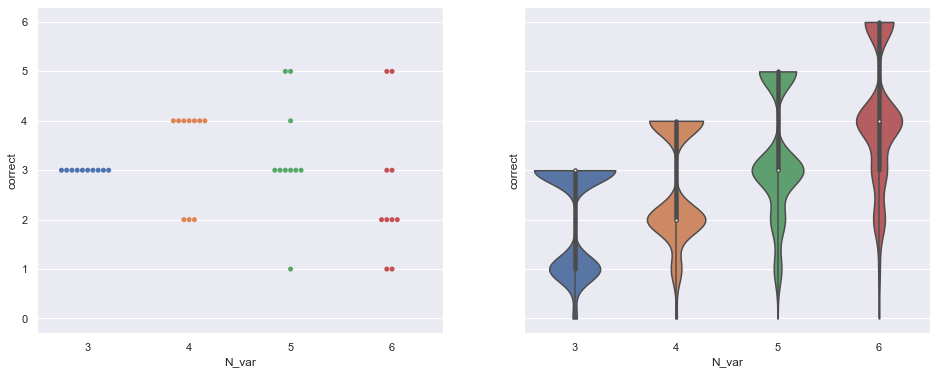

In [65]:
sim_data = exp1.simulate(lambda: SwapWM(**swap_best_params))
plot_sim(sim_data)

In [67]:
class BetaSwapWM(SwapWM):
    def __init__(self, alpha_swap, beta_swap):
        self.chunks = []
        self.alpha_swap = alpha_swap
        self.beta_swap = beta_swap

    def maybe_swap(self):
        p_swap = dist.Beta(len(self.chunks) * self.alpha_swap + self.beta_swap, 1).sample()
        if dist.Bernoulli(p_swap).sample().item() == 1.:
            self.swap()           

  0%|          | 260/9223372036854775807 [02:00<1183761060173785:27:28,  2.16trial/s, best loss: 1.3166666666666667]
Best params: 
{'alpha_swap': 1.3258126362958946, 'beta_swap': -4.799011564115427}
Parameter space: 


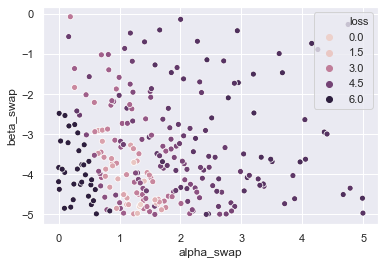

In [73]:
betaswap_param_space = [
    hp.uniform('alpha_swap', 0, 5),
    hp.uniform('beta_swap', -5, 0)
]

betaswap_best_params, betaswap_all_params = pcache.get(
    'betaswap_params', lambda: exp1.param_search(BetaSwapWM, betaswap_param_space))

print('Best params: ')
pprint(betaswap_best_params)
print('Parameter space: ', )
sns.scatterplot(data=betaswap_all_params, x='alpha_swap', y='beta_swap', hue='loss')

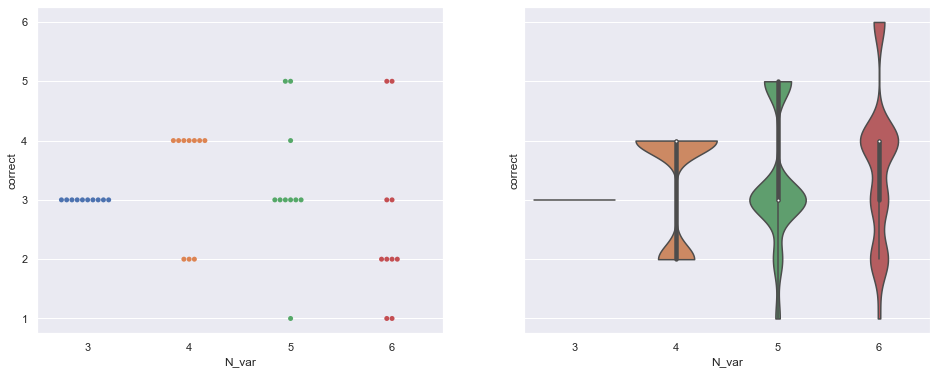

In [74]:
sim_data = exp1.simulate(lambda: BetaSwapWM(**betaswap_best_params))
plot_sim(sim_data)

# 2. Arithmetic

Next, we want to consider the interaction between memory for variables and computation involving those variables. [Resarch in mental arithmetic](https://www.tandfonline.com/doi/abs/10.1080/09541440244000328) suggests that performing arithmetic can interact with memory in a number of ways:

- Intermediates in large expressions (e.g. x + y + z + ...) have to be held in working memory.
- Performing arithmetic requires accessing arithmetic rules in STM or LTM.
- More challenging arithmetic (e.g. 372 / 12) induces a heavier cognitive load on working memory.

To avoid the latter two issues as much as possible, we will stick to the simplest possible calculations (addition and subtraction, small constants). To test the memory-arithmetic interaction, we will consider a simple extension of the previous experiment.

## 2.1. Experiment 2: Variables and arithmetic

**Method:** for $N_{var} = 2 \ldots 5$, the participant is shown $N_{var}$ variable bindings exactly as described in Experiment 1. After showing a blank screen for 1 second, the participant is prompted with an arithmetic expression using all of the variables on the prior screen. e.g.

```python
y - z + x
```

The variable order is randomized, and the binary operators are randomized as well. The participant is prompted for a numeric answer, with no time limit to answer. 

Under an Occam's razor / null hypothesis that arithmetic has no effect on working memory, we hypothesize that the mean correct response should be approximate the probability of correctly memorizing all $N_{var}$ variables in the prior experiment. 

**Results:** for each trial, we computed whether the participant answered correctly (1) or not (0). The mean and standard deviation of responses is shown below:

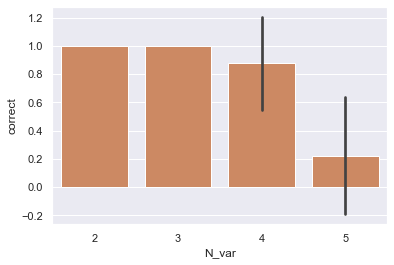

In [75]:
exp2 = VariableArithmeticExperiment()
sns.barplot(data=exp2.results(), x='N_var', y='correct', palette=[sns.color_palette()[1]], ci='sd')

Consistent with the null hypothesis, the mean correctness appears to match the probability of memorizing all variables. Hence, our model should produce similar results without changing the underlying parameters.

## 2.2. Arithmetic model

We model the participant like an interpreter with a faulty store, where any forgotten variable is replaced with a guess.

In [76]:
from grammar import *

class TraceWM(BetaSwapWM):
    def trace_expr(self, expr):
        if isinstance(expr, Number):
            return expr.n
        elif isinstance(expr, Var):
            val = self.load(expr.var)
            if val is not None:
                return val
            else:
                return randint(1, 9)
        elif isinstance(expr, Binop):
            left = self.trace_expr(expr.left)
            right = self.trace_expr(expr.right)
            result = expr.operator.eval(left, right)
            return result
        
    def trace_stmt(self, stmt):
        if isinstance(stmt, Assign):
            val = self.trace_expr(stmt.value)
            self.store(stmt.var, val)
        elif isinstance(stmt, Expr):
            return self.trace_expr(stmt.value)

We can then simulate the model in this experiment under the same parameters as before, and compare the results:

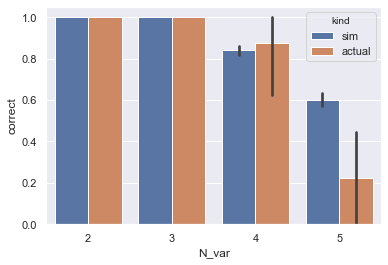

In [77]:
sim = exp2.simulate(model=lambda: TraceWM(**betaswap_best_params))

actual = exp2.results()
sim['kind'] = 'sim'
actual['kind'] = 'actual'

sns.barplot(data=pd.concat([sim, actual]), x='N_var', y='correct', hue='kind')

As expected, the mean correctness of the model is similar to the simulated probability of getting all variables correct, which was close to the actual probability. Therefore the model still approximates the actual data well on this task.

# 3. Processes

In the prior experiments, all memorization was done in one stage, followed by all calculation in another. To test  whether the model generalizes to other situations, we can consider a multi-stage process that interleaves memorization and calculation, similar to [Campbell and Charness](https://psycnet.apa.org/record/1991-06940-001).

## 3.1. Experiment 3: Multi-step arithmetic

**Method:** in each trial, the participant follows a randomly generated series of arithmetic statements of the form `var = left binop right`. The 0-th stage is always a constant assignment `var = constant`. Following this, the operands are randomly assigned to be either a random prior variable or a constant. 

The participant is shown one stage at a time. At each stage, the participant is prompted to input the value of the variable, e.g. if `x = 3 + y` is shown and previously `y = 4`, then the participant should enter `7`. After entering a value, if it is correct, the next stage is shown after 1s. If it is incorrect, the trial is over, and the participant goes to the next trial.

**Results:** following Campbell and Charness, for each trial we identify the stage at which the participant makes an error. Then we classify the error as either a "substitution" error or a "calculation" error. For example, consider this sequence;

```python
x = 1
y = x + 1
z = y + 2
```

On the 2nd stage (`z`), the correct answer is 4. If the participant responds 3, this is classified as a substitution error because it can be plausibly explained by remembering `y` as the value of `x`. If the participant's answer cannot be plausibly explained by such a substitution, it's considered a calculation error (which could also just be totally forgetting).

Below, we plot the histogram of errors per type of error.

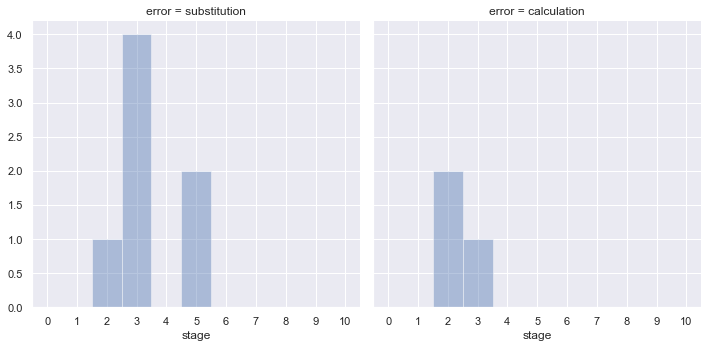

In [32]:
exp3 = VariableSequenceExperiment()

def plot_errors(df):
    bins = list(range(11))
    g = sns.FacetGrid(data=df, col='error', height=5, xlim=(bins[0]-0.5, bins[-1]+0.5),
                      col_order=['substitution', 'calculation'])
    g.map(sns.distplot, 'stage', bins=np.arange(bins[0]+0.5, bins[-1]+0.5), kde=False)
    g.set(xticks=bins)
    g.set_xticklabels(bins)
    
exp3_results = exp3.process_results(0, 10)    
plot_errors(exp3_results)

A key observation is that this data is, on the face of it, inconsistent with prior trials. Previously, up to 3 variables were always remembered with 100% accuracy. Here, a number of errors are made as soon as the second stage (having seen only two variables). 

Given this, we hypotheisze that our model should be inconsistent with the actual data. Simulating the experiment, we get:

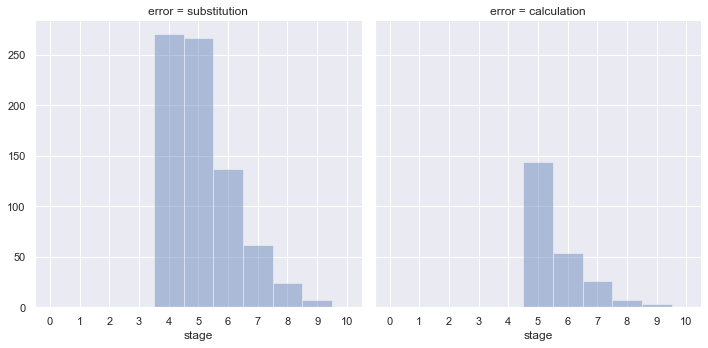

In [33]:
sim = exp3.simulate(lambda: TraceWM(**best_params_swap))
plot_errors(sim)

Indeed, under our model, we would predict zero errors until stage 4 and beyond. What could explain this discrepancy?

In prior experiments, variables were assigned to small constant values. Now, variables are assigned to arithmetic expressions. This means a variable can be assigned to a wider range of values. Unlike previously, where each variable was guaranteed to be used exactly once, a variable in Experiment 3 can be used many or no times at all.

Another change is that of time and decay. Previous experiments had little wall-clock time between the definition and use of a variable. Here, a variable could potentially used be dozens of seconds after it is defined.